# Install Environment

In [ ]:
!pip install python-dotenv
!pip install --upgrade scikit-image

# Import Library

In [4]:
# untuk melakukan permintaan HTTP ke sumber daya eksternal seperti API atau situs web
import requests 

# untuk memisahkan variable token ketika diakses di file utama
# ketika showcase codingan maka tokennya tidak terlihat
from dotenv import load_dotenv

# untuk berinteraksi dengan sistem operasi. Untuk mengakses variabel lingkungan, mengubah direktori kerja, membuat direktori, menghapus berkas, dsb
import os 

# menggunakannya untuk membaca, menulis, dan memanipulasi gambar, mengaplikasikan filter dan efek, melakukan deteksi objek, dsb
import cv2 

# untuk komputasi numerik. seperti konversi list menjadi array, menghitung statistik, dan memanipulasi array
import numpy as np

# digunakan untuk pemisahan dataset menjadi subset train dan test secara acak
from sklearn.model_selection import train_test_split 

# digunakan untuk mencari puncak lokal dalam citra. Ini berguna dalam algoritma segmentasi Watershed, di mana puncak lokal digunakan sebagai titik awal segmentasi.
from skimage.feature import peak_local_max 

# digunakan untuk menerapkan algoritma segmentasi Watershed pada citra
from skimage.segmentation import watershed

# pemrosesan citra dan data multidimensi, digunakan untuk melakukan transformasi jarak dan operasi pemrosesan citra lainnya yang diperlukan dalam algoritma segmentasi Watershed
from scipy import ndimage 

# membuat plot dan visualisasi data
import matplotlib.pyplot as plt 

# Modul cm menyediakan berbagai peta warna (colormap) yang digunakan untuk visualisasi data dalam plot. peta warna seperti 'cool', 'hot', 'viridis', 'cividis', dan banyak lagi
from matplotlib import cm

# menghasilkan angka acak
import random

# melakukan operasi pada file dan direktori, seperti menghapus atau menyalin file
import shutil

# membaca dan menulis gambar
from skimage import io

# Citra RGB

In [14]:
image_path = 'image1.png'

(-0.5, 731.5, 480.5, -0.5)

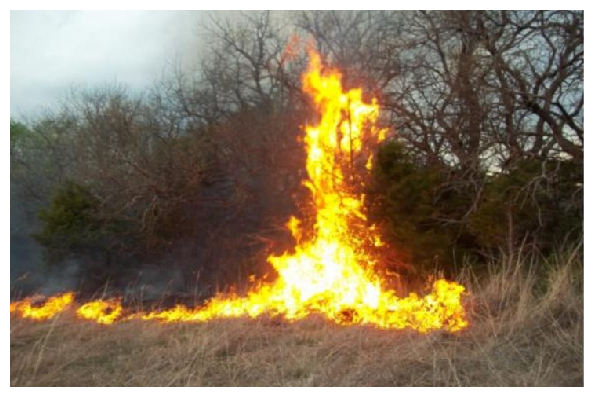

In [16]:
image = io.imread(image_path)
io.imshow(image)
plt.axis('off')

### Definisi fungsi utama

In [5]:
def apply_threshold(image, thresh_val):
    _, thresholded = cv2.threshold(image, thresh_val, 255, cv2.THRESH_BINARY)
    return thresholded

### Kombinasi HSV dan Threshold

In [22]:
def combinate_hsv_threshold(image):
    # convert the image in hsv
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    h_channel, s_channel, v_channel = cv2.split(hsv_image)

    h_thresholded = apply_threshold(h_channel, 163)
    s_thresholded = apply_threshold(s_channel, 163)
    v_thresholded = apply_threshold(v_channel, 163)

    # Merging the thresholded channel
    thresholded_merged_channel = cv2.merge((h_thresholded, s_thresholded, v_thresholded))

    # Apply thresholding
    thresholded = apply_threshold(hsv_image, 163)

    # Simpan citra HSV
    cv2.imwrite('./hsv.png', thresholded)

    thresholded = io.imread('./hsv.png')
    
    return thresholded

(-0.5, 731.5, 480.5, -0.5)

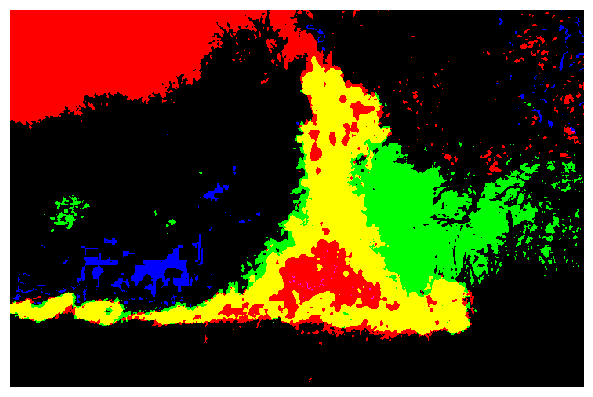

In [23]:
image = cv2.imread(image_path)
apply_method = combinate_hsv_threshold(image)

# Normalisasi citra
normalized_image = apply_method.astype(float) / 255.0

# Simpan citra hasil thresholding
normalized_image_uint8 = (normalized_image * 255).astype(np.uint8)

io.imshow(normalized_image_uint8)
plt.axis('off')

### Kombinasi Grayscale dan Threshold

In [24]:
def combinate_grayscale_threshold(image):
    # panggil method combinate_hsv_threshold
    hsv_threshold = combinate_hsv_threshold(image)
    
    # Convert HSV to grayscale
    grayscale_image = cv2.cvtColor(hsv_threshold, cv2.COLOR_BGR2GRAY)
    
    # Apply thresholding
    thresholded = apply_threshold(grayscale_image, 163)
    
    return thresholded

(-0.5, 731.5, 480.5, -0.5)

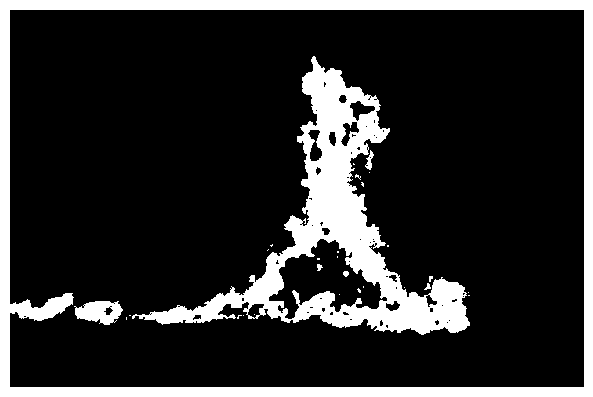

In [25]:
image = cv2.imread(image_path)
apply_method = combinate_grayscale_threshold(image)

# Normalisasi citra
normalized_image = apply_method.astype(float) / 255.0

# Simpan citra hasil thresholding
normalized_image_uint8 = (normalized_image * 255).astype(np.uint8)

io.imshow(normalized_image_uint8)
plt.axis('off')

# Menggambar Kontur

In [28]:
def contour(image):
    # panggil method combinate_grayscale_threshold
    grayscale_threshold = combinate_grayscale_threshold(image)
    
    # Find contours
    contours, _ = cv2.findContours(grayscale_threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours on the image
    contour_image = cv2.drawContours(image, contours, -1, (0, 255, 0), 2)
    
    cv2.imwrite('./contour.png', contour_image)

    contour = io.imread('./contour.png')
    
    # return thresholded

    return contour


(-0.5, 731.5, 480.5, -0.5)

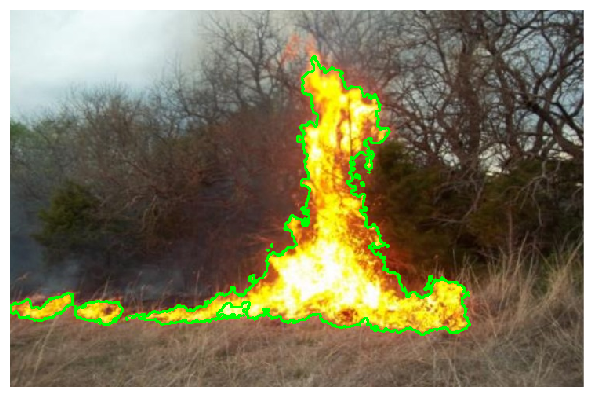

In [29]:
image = cv2.imread(image_path)
apply_method = contour(image)

# Normalisasi citra
normalized_image = apply_method.astype(float) / 255.0

# Simpan citra hasil thresholding
normalized_image_uint8 = (normalized_image * 255).astype(np.uint8)

io.imshow(normalized_image_uint8)
plt.axis('off')

# Morphologi Terbuka

In [30]:
def morphologi_terbuka(image):
    # panggil method combinate_grayscale_threshold
    grayscale_threshold = combinate_grayscale_threshold(image)
    
    # Remove noise by median blur
    filtered_image = cv2.medianBlur(grayscale_threshold, 3)
    combined = filtered_image
    
    # Noise removal
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
    opening = cv2.morphologyEx(combined, cv2.MORPH_OPEN, kernel, iterations=2)
    
    return opening

(-0.5, 731.5, 480.5, -0.5)

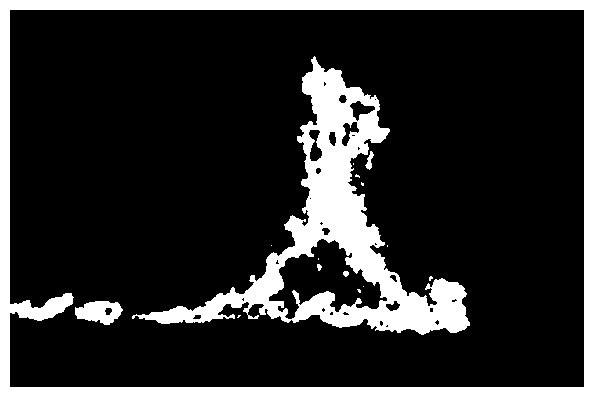

In [31]:
image = cv2.imread(image_path)
apply_method = morphologi_terbuka(image)

# Normalisasi citra
normalized_image = apply_method.astype(float) / 255.0

# Simpan citra hasil thresholding
normalized_image_uint8 = (normalized_image * 255).astype(np.uint8)

io.imshow(normalized_image_uint8)
plt.axis('off')

# Transformasi Jarak

In [32]:
def transformasi_jarak(image):
    # panggil method morphologi_terbuka
    morfologi = morphologi_terbuka(image)
    
    # Sure foreground area
    dist_transform = cv2.distanceTransform(morfologi, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.01 * dist_transform.max(), 255, 0)
    
    sure_bg = cv2.subtract(morfologi, sure_fg.astype(np.uint8))

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    
    # panggil method combinate_grayscale_threshold
    thresholded_image = combinate_grayscale_threshold(image)
    
    # Perform distance transform on the binary image
    distance_transform = cv2.distanceTransform(thresholded_image, cv2.DIST_L2, 3)
    
    return distance_transform

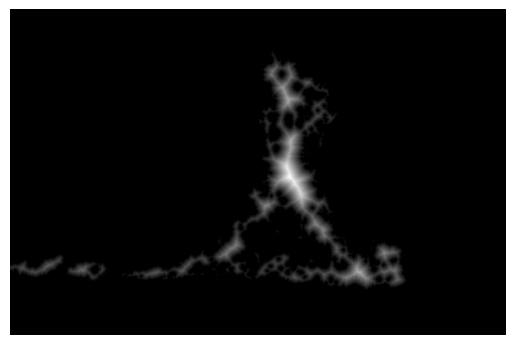

In [35]:
image = cv2.imread(image_path)
apply_method = transformasi_jarak(image)

# Normalisasi citra
normalized_image = apply_method.astype(float) / 255.0

# Simpan citra hasil thresholding
normalized_image_uint8 = (normalized_image * 255).astype(np.uint8)

plt.imshow(normalized_image_uint8, cmap='gray')
plt.axis('off')
plt.show()

# Segmentasi Watershed

In [36]:
def segmentasi_watershed(image):
    # panggil method transformasi_jarak
    distance_transform = transformasi_jarak(image)
    
    # panggil method combinate_grayscale_threshold
    thresholded_image = combinate_grayscale_threshold(image)
    
    # Find peaks in the distance transform
    # coordinates = peak_local_max(distance_transform, min_distance=9, labels=thresholded_image)
    coordinates = peak_local_max(distance_transform, min_distance=10, labels=thresholded_image)

    # Create markers for watershed segmentation
    markers = np.zeros(thresholded_image.shape, dtype=np.int32)
    for i in range(len(coordinates)):
        # markers[coordinates[i][0], coordinates[i][1]] = i + 1
        markers[coordinates[i][0], coordinates[i][1]] = i + 15

    # Perform watershed segmentation
    labels = watershed(-distance_transform, markers, mask=thresholded_image)

    # Tentukan rentang warna dari merah ke biru
    color_map = cm.get_cmap('cool')

    # Assign warna ke setiap piksel segmentasi berdasarkan jarak transformasi
    segmentation_color = np.zeros(image.shape, dtype=np.uint8)
    for i in range(np.max(labels)):
        color = color_map(i / np.max(labels))[:3]  # Ambil komponen RGB dari colormap
        color = tuple(int(c * 255) for c in color)  # Konversi nilai 0-1 ke 0-255
        x, y = np.where(labels == i + 1)  # Dapatkan koordinat piksel dengan label yang sesuai
        segmentation_color[x, y] = color
    
    # Berikan warna pada latar belakang
    background_color = (188, 159, 42)  # Warna kuning untuk latar belakang (format BGR) 
    background_pixels = np.where(labels == 0)  # Dapatkan koordinat piksel latar belakang
    segmentation_color[background_pixels] = background_color
    
    return segmentation_color

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2340\4237589604.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('cool')


(-0.5, 731.5, 480.5, -0.5)

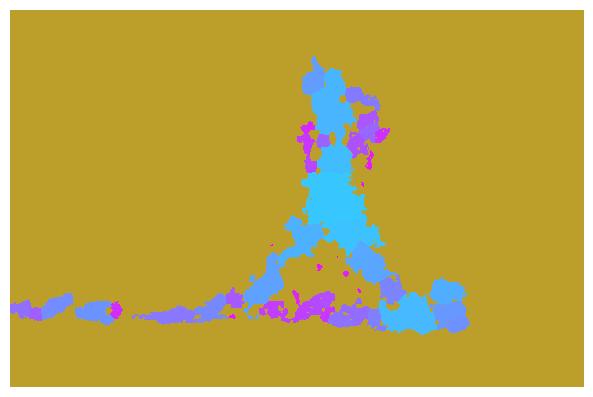

In [38]:
image = cv2.imread(image_path)
apply_method = segmentasi_watershed(image)

# Normalisasi citra
normalized_image = apply_method.astype(float) / 255.0

# Simpan citra hasil thresholding
normalized_image_uint8 = (normalized_image * 255).astype(np.uint8)

io.imshow(normalized_image_uint8)
plt.axis('off')

# Penggabungan Citra

In [40]:
def penggabungan_citra(image):
    # panggil method segmentasi_watershed
    segmentation_color = segmentasi_watershed(image)
    
    # panggil method segmentasi_watershed
    image_contour = contour(image)
    
    # Resize or crop image_contour to match the size of segmentation_color
    image_contour = cv2.resize(image_contour, (segmentation_color.shape[1], segmentation_color.shape[0]))
    
    # Gabungkan citra contour dengan citra segmentasi warna
    merged_image = cv2.addWeighted(segmentation_color, 0.7, image_contour, 0.3, 0)

    return merged_image

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2340\4237589604.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('cool')


(-0.5, 731.5, 480.5, -0.5)

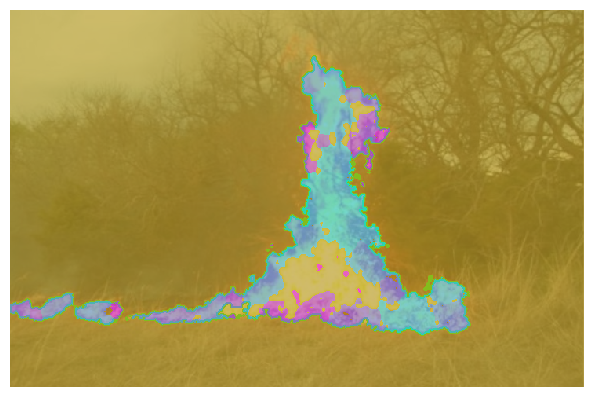

In [41]:
image = cv2.imread(image_path)
apply_method = penggabungan_citra(image)

# Normalisasi citra
normalized_image = apply_method.astype(float) / 255.0

# Simpan citra hasil thresholding
normalized_image_uint8 = (normalized_image * 255).astype(np.uint8)

io.imshow(normalized_image_uint8)
plt.axis('off')

# Try to Apply penggabungan_citra Method

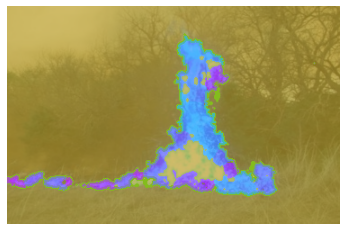

In [15]:
image_path = 'image1.png'
image = cv2.imread(image_path)

apply_method = penggabungan_citra(image)

# Normalisasi citra
normalized_image = apply_method.astype(float) / 255.0

# Simpan citra hasil thresholding
normalized_image_uint8 = (normalized_image * 255).astype(np.uint8)
# plt.imsave('./dataset/image1_final.png', normalized_image_uint8)

plt.imshow(normalized_image_uint8)
plt.axis('off')
plt.show()

# Melakukan contour dan menyimpan citra hasil contour

In [ ]:
# # Path folder citra asli
# input_folder = "./dataset/fire_images"

# # Path folder untuk menyimpan citra hasil segmentasi
# output_folder = "./contour/contour_images"

# # Membuat folder output jika belum ada
# if not os.path.exists(output_folder):
#     os.makedirs(output_folder)

# # Loop melalui semua file citra dalam folder input
# for filename in os.listdir(input_folder):
#     image_path = os.path.join(input_folder, filename)
    
#     # Baca citra
#     image = io.imread(image_path)
    
#     # Lakukan contour
#     contour_image = contour(image)

#     # Normalisasi citra
#     normalized_image = contour_image.astype(float) / 255.0

#     # Simpan citra hasil thresholding
#     normalized_image_uint8 = (normalized_image * 255).astype(np.uint8)
    
#     # Buat path untuk citra hasil segmentasi
#     output_path = os.path.join(output_folder, "contour_" + filename)
    
#     # Simpan citra hasil segmentasi
#     io.imsave(output_path, contour_image)

# Melakukan segmentasi dan menyimpan citra hasil segmentasi

In [ ]:
# # Path folder citra asli
# input_folder = "./dataset/fire_images"

# # Path folder untuk menyimpan citra hasil segmentasi
# output_folder = "./final_segmented_images"

# # Membuat folder output jika belum ada
# if not os.path.exists(output_folder):
#     os.makedirs(output_folder)
    
# # Loop melalui semua file citra dalam folder input
# for filename in os.listdir(input_folder):
#     image_path = os.path.join(input_folder, filename)
    
#     # Baca citra
#     image = io.imread(image_path)
    
#     # Lakukan segmentasi
#     segmented_image = penggabungan_citra(image)

#     # Normalisasi citra
#     normalized_image = segmented_image.astype(float) / 255.0

#     # Simpan citra hasil thresholding
#     normalized_image_uint8 = (normalized_image * 255).astype(np.uint8)
    
#     # Buat path untuk citra hasil segmentasi
#     output_path = os.path.join(output_folder, "segmented_" + filename)
    
#     # Simpan citra hasil segmentasi
#     io.imsave(output_path, segmented_image)